# Assignment: Dynamic Programming - The Gambler's Problem

**Objective:** Implement and compare Value Iteration and Policy Iteration to solve the Gambler's Problem as described in Chapter 4 of Sutton and Barto's Reinforcement Learning: An Introduction.

## The Gambler's Problem

A gambler has the opportunity to make bets on the outcomes of a sequence of coin flips. If the coin comes up heads, he wins as many dollars as he has staked on that flip, if it is tails, he loses his stake. The game ends when the gambler wins by reaching his goal of 100 USD, or loses by running out of money (capital is 0 USD).

This problem can be formulated as an undiscounted, episodic, finite MDP:

-   **States ($s$):** The gambler's capital, $s \in \{1, 2, \dots, 99\}$. The states $s = 0$ and $s = 100$ are terminal states.
-   **Actions ($a$):** The integer amount to stake, $a \in \{1, 2, \dots, \min(s, 100-s)\}$.
-   **Reward ($R$):** The reward is +1 on the transition to the winning state ($100), and 0 on all other transitions.

-   **Transitions ($p(s'|s,a)$):** From a state $s$, after taking action $a$, the gambler's capital will become $s+a$ with probability $p_h$ (the probability of heads) and $s-a$ with probability $1-p_h$.
-   **Discount Factor ($\gamma$):** 1 (undiscounted).

Your objective is to find an optimal policy, $\pi^*(s)$, which maps each capital level to a stake amount, that maximizes the probability of reaching the goal of 100 USD. The value of a state $s$, $V(s)$, is then the probability of winning starting with capital $s$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Part 1: Value Iteration

Value Iteration finds the optimal value function $V^*$ by turning the Bellman Optimality Equation into an iterative update.

**General Bellman Optimality Equation:**
$$V_{k+1}(s)  =  \max_{a} \sum_{s', r} p(s', r | s, a) [r + \gamma V_k(s')]$$

**For the Gambler's Problem, this becomes:**
$$V_{k+1}(s)  =  \max_{a \in \{1, ..., \min(s, 100-s)\}} \Big[ p_h \cdot (R_{s+a} + \gamma V_k(s+a)) + (1-p_h) \cdot (R_{s-a} + \gamma V_k(s-a)) \Big]$$
Where $R_{s+a} = 1$ if $s+a = 100$, and 0 otherwise.

### Your Task:
Implement the `value_iteration` method in the `GamblersProblem` class below. You will need to:
1. Loop until the value function converges (for example, the maximum change between sweeps, `delta`, is less than `theta`).
2. In each sweep, loop through all states $s \in \{1, ..., 99\}$.
3. For each state, find the action that maximizes the expected future value.
4. Update the value function `V[s]` with this maximum value.
5. After the value function has converged, extract the optimal policy.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class GamblersProblem:
    def __init__(self, p_h=0.4, gamma=1.0, theta=1e-9):
        self.p_h = p_h                # Probability of heads
        self.gamma = gamma           
        self.theta = theta           
        self.states = np.arange(101)  
        self.V = np.zeros(101)        
        self.V[100] = 1.0             
        self.policy = np.zeros(101, dtype=int)

    def value_iteration(self):
        """Performs the Value Iteration algorithm to find the optimal value function."""
        sweep = 0
        history = [self.V.copy()]

        while True:
            delta = 0
            for s in range(1, 100):  
                old_v = self.V[s]

                
                actions = range(1, min(s, 100 - s) + 1)

                
                action_returns = []
                for a in actions:
                    win_state = s + a
                    lose_state = s - a
                    reward = 1.0 if win_state == 100 else 0.0
                    val = (
                        self.p_h * (reward + self.gamma * self.V[win_state]) +
                        (1 - self.p_h) * (self.gamma * self.V[lose_state])
                    )
                    action_returns.append(val)

                
                self.V[s] = max(action_returns) if action_returns else 0
                delta = max(delta, abs(old_v - self.V[s]))

            sweep += 1
            history.append(self.V.copy())
            if delta < self.theta:
                break

        print(f"Value Iteration converged after {sweep} sweeps.")

        # Policy extraction
        for s in range(1, 100):
            actions = range(1, min(s, 100 - s) + 1)
            best_action = 0
            best_value = -float("inf")
            for a in actions:
                win_state = s + a
                lose_state = s - a
                reward = 1.0 if win_state == 100 else 0.0
                val = (
                    self.p_h * (reward + self.gamma * self.V[win_state]) +
                    (1 - self.p_h) * (self.gamma * self.V[lose_state])
                )
                if val > best_value:
                    best_value = val
                    best_action = a
            self.policy[s] = best_action

        return history, self.policy, self.V

    def plot_value_function_history(self, history):
        plt.figure(figsize=(12, 8))
        plot_indices = np.unique(np.logspace(0, np.log10(len(history)-1), 5, dtype=int))
        for i in plot_indices:
            plt.plot(self.states[1:100], history[i][1:100], label=f'Sweep {i}')
        plt.title('Value Function Estimates over Sweeps (Value Iteration)')
        plt.xlabel('Capital')
        plt.ylabel('Value (Probability of Winning)')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_policy(self):
        plt.figure(figsize=(12, 8))
        plt.step(self.states[1:100], self.policy[1:100])
        plt.title('Final Policy (Stake vs. Capital)')
        plt.xlabel('Capital')
        plt.ylabel('Stake')
        plt.grid(True)
        plt.show()


Value Iteration converged after 18 sweeps.


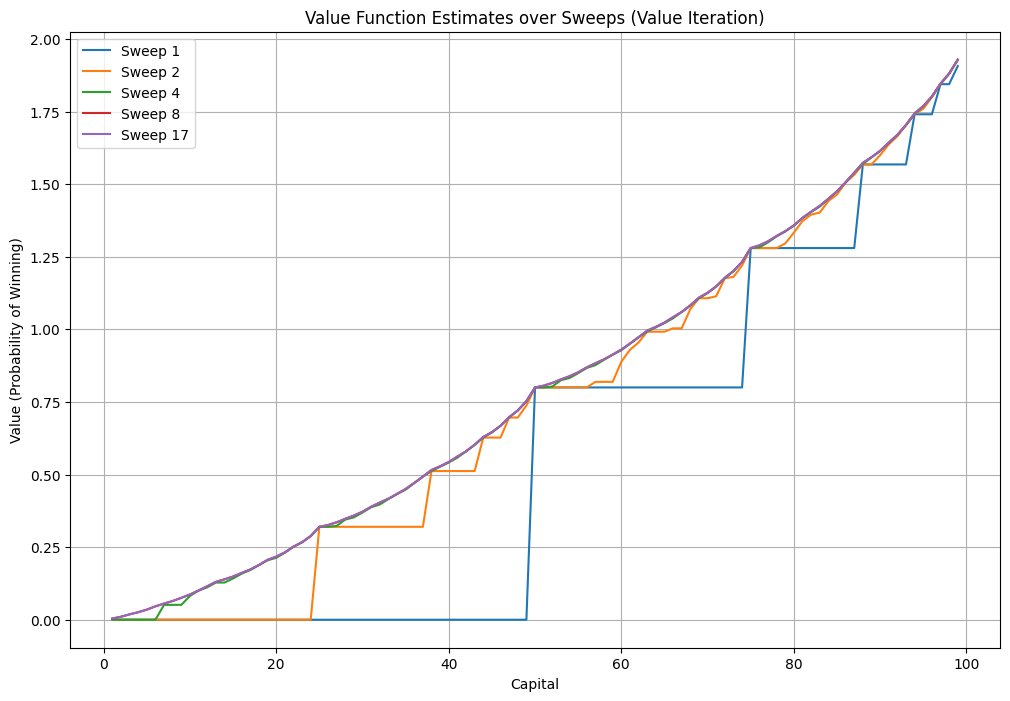

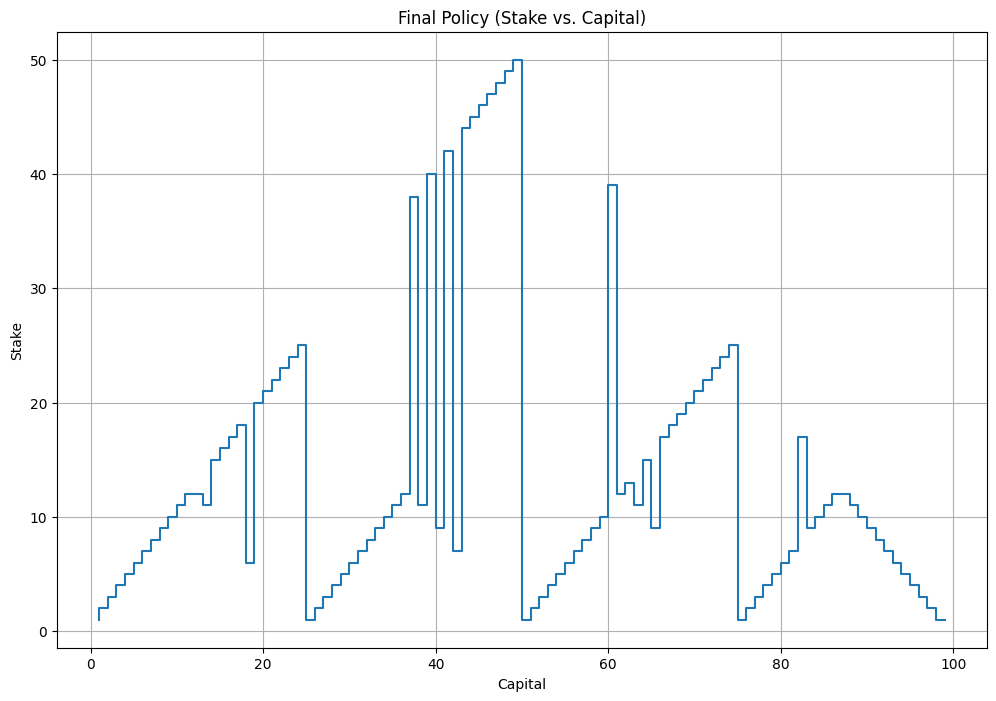

In [3]:
# here you run your Value Iteration
gambler_vi  =  GamblersProblem(p_h = 0.4)
vi_history, vi_policy, vi_values  =  gambler_vi.value_iteration()

gambler_vi.plot_value_function_history(vi_history)
gambler_vi.plot_policy()

## Part 2: Policy Iteration

Policy Iteration alternates between two steps:
1. **Policy Evaluation:** Given a policy $\pi$, compute the value function $V^\pi$. This is done by repeatedly applying the Bellman Expectation Equation until convergence.
   $$V_{k+1}^{\pi}(s)  =  \sum_{s', r} p(s', r | s, \pi(s)) [r + \gamma V_k^{\pi}(s')]$$
   **For the Gambler's Problem:**
   $$V_{k+1}^{\pi}(s)  =  p_h \cdot (R_{s+\pi(s)} + \gamma V_k^{\pi}(s+\pi(s))) + (1-p_h) \cdot (R_{s-\pi(s)} + \gamma V_k^{\pi}(s-\pi(s)))$$

2. **Policy Improvement:** Given the value function $V^\pi$, improve the policy by acting greedily with respect to it.
   $$\pi'(s)  =  \arg\max_{a} \sum_{s', r} p(s', r | s, a) [r + \gamma V^\pi(s')]$$

The process stops when the policy is stable (for example it doesn't change after an improvement step).

### Your Task:
Implement the `policy_iteration`, `policy_evaluation`, and `policy_improvement` methods.
1.  **`policy_evaluation`**: This will be a loop inside your main `policy_iteration` loop. It should update `self.V` for the *current* fixed policy `self.policy` until convergence.
2.  **`policy_improvement`**: This will iterate through all states and find the greedy action with respect to the *newly evaluated* `self.V`. It should update `self.policy` and return `True` if the policy is stable, `False` otherwise.

In [4]:
class GamblersProblemPI(GamblersProblem):
    def __init__(self, p_h=0.4, gamma=1.0, theta=1e-9):
        super().__init__(p_h, gamma, theta)
        self.policy = np.ones(101, dtype=int)
        self.policy[0] = 0
        self.policy[100] = 0

    def policy_evaluation(self):
        """Iterative policy evaluation for the current policy."""
        while True:
            delta = 0
            for s in range(1, 100):
                v = self.V[s]
                a = self.policy[s]
                win_state = s + a
                lose_state = s - a
                reward = 1.0 if win_state == 100 else 0.0
                self.V[s] = (
                    self.p_h * (reward + self.gamma * self.V[win_state]) +
                    (1 - self.p_h) * (self.gamma * self.V[lose_state])
                )
                delta = max(delta, abs(v - self.V[s]))
            if delta < self.theta:
                break

    def policy_improvement(self):
        """Improves the policy greedily with respect to the current value function."""
        policy_stable = True
        for s in range(1, 100):
            old_action = self.policy[s]
            actions = range(1, min(s, 100 - s) + 1)
            best_action = 0
            best_value = -float("inf")

            for a in actions:
                win_state = s + a
                lose_state = s - a
                reward = 1.0 if win_state == 100 else 0.0
                val = (
                    self.p_h * (reward + self.gamma * self.V[win_state]) +
                    (1 - self.p_h) * (self.gamma * self.V[lose_state])
                )
                if val > best_value:
                    best_value = val
                    best_action = a

            self.policy[s] = best_action
            if old_action != best_action:
                policy_stable = False
        return policy_stable

    def policy_iteration(self):
        """Performs the Policy Iteration algorithm."""
        iteration = 0
        policy_history = [self.policy.copy()]
        while True:
            self.policy_evaluation()
            policy_stable = self.policy_improvement()
            policy_history.append(self.policy.copy())
            iteration += 1
            if policy_stable:
                break

        print(f"Policy Iteration converged after {iteration} iterations.")
        return policy_history, self.policy, self.V

    def plot_policy_history(self, history):
        plt.figure(figsize=(12, 8))
        plot_indices = np.unique(np.linspace(0, len(history)-1, 5, dtype=int))
        for i in plot_indices:
            plt.plot(self.states[1:100], history[i][1:100], label=f'Iteration {i}')
        plt.title('Policy Evolution over Iterations')
        plt.xlabel('Capital')
        plt.ylabel('Stake')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_value_function(self):
        plt.figure(figsize=(12, 8))
        plt.plot(self.states[1:100], self.V[1:100])
        plt.title('Final Value Function (Policy Iteration)')
        plt.xlabel('Capital')
        plt.ylabel('Value (Probability of Winning)')
        plt.grid(True)
        plt.show()


Policy Iteration converged after 16 iterations.


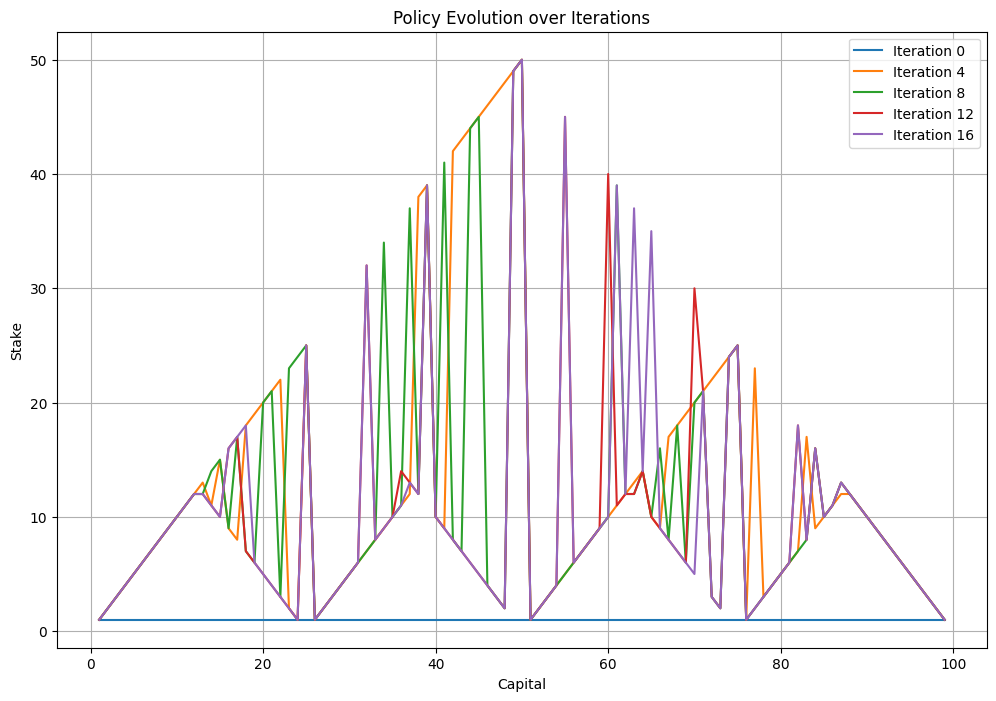

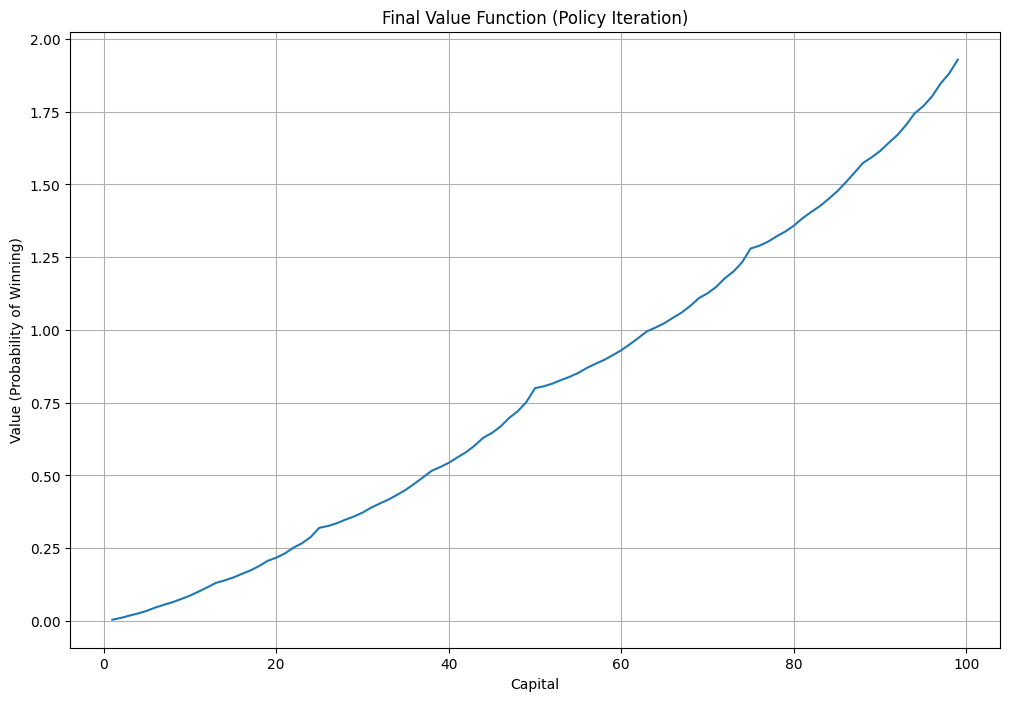

In [5]:
# Here you run your Policy Iteration
gambler_pi  =  GamblersProblemPI(p_h = 0.4)
pi_history, pi_policy, pi_values  =  gambler_pi.policy_iteration()

gambler_pi.plot_policy_history(pi_history)
gambler_pi.plot_value_function()